In [1]:
import collections
import seaborn as sns
import subprocess
import numpy as np
import itertools as it
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from  imp import reload
import sys
sys.path.insert(1, '../mallows_kendall')
sys.path.insert(1, '../permus_util')

import mallows_kendall as mk
import permutil as pu

# check 
that the distance to the sample is done in $O(n)$

In [2]:
def sum_dist_slow(sample,perm):
  return np.sum([mk.kendall_tau(perm,p) for p in sample])/len(sample)

m,n = 100,5
s0 = np.random.permutation(n)
sample = np.array(mk.sampling_mm(m,n,phi=0.5,s0=s0))
P = pu.sample_to_marg_rel(sample)
P[P==0]=np.nan
# print(P,np.tril(P[np.ix_(np.argsort(perm),np.argsort(perm))],k=-1))
print("error in dists", pu.dist_to_sample(s0,P) - sum_dist_slow(sample,s0))
print("error in dists", pu.dist_to_sample(s0[::-1],P) - sum_dist_slow(sample,s0[::-1]))
print("error in dists", pu.dist_to_sample(np.arange(n),P) - sum_dist_slow(sample,np.arange(n)))


error in dists 0.0
error in dists -4.440892098500626e-16
error in dists 0.0


# Funtions to generate pairwise matrices
of strongly stochastive preferences of two types: random (` model == p_sst`)and following a Mallos model (`model='mal_ken'`)


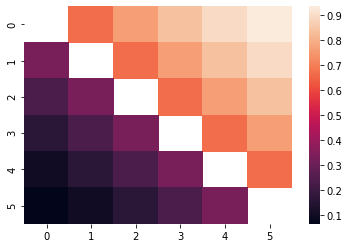

In [3]:
def closed_form_pairwise(n,model='mal_ken',phi=None,theta=None):
  def h(k,phi):return k/(1-phi**k)
  pairw = np.empty((n,n))
  pairw[:] = np.nan
  if model=='mal_ken':
    theta, phi = mk.check_theta_phi(theta, phi)
    for i in range(n):
      for j in range(i+1,n):
        pairw[i,j] = h(j-i+1,phi) - h(j-i,phi)
        pairw[j,i] = 1-pairw[i,j]
  elif model == 'p_sst': # generate a pairwise
    aux = np.concatenate([[0] , np.random.uniform(low=0.5, high=1, size=(n-1)) ])
    aux.sort()
    for i in range(n):
      pairw[i] = aux
      aux = np.roll(aux, 1)
    for i in range(n):#make symmetric
      for j in range(i+1,n):
        pairw[j,i] = 1-pairw[i,j]
  return pairw

n = 6
P = closed_form_pairwise(n,model='mal_ken', phi=0.5)
# P = closed_form_pairwise(n,model='p_sst')
sns.heatmap(P)
res  = []
for perm in it.permutations(range(n)):
  res.append([n*(n-1)/2 - pu.dist_to_sample(perm,P), mk.kendall_tau(perm),perm, mk.ranking_to_v(perm)])
df = pd.DataFrame(res,columns=['depth','dist','perm','v'])
             

# How many contours are there?

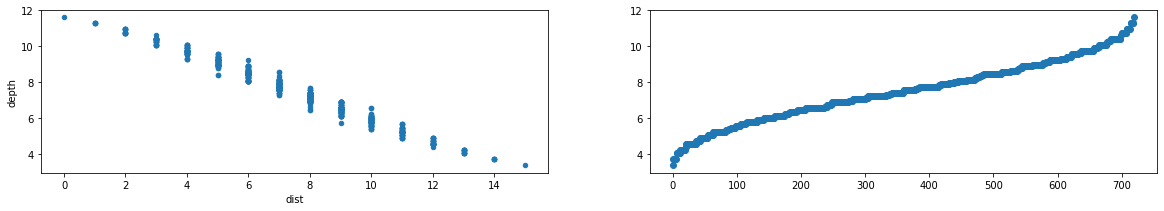

In [4]:
fig, ax = plt.subplots(1, 2,figsize=(20,3))
aux = df.copy()
# aux.depth -= aux.depth.min()
# aux.depth /= aux.depth.max()
aux.plot.scatter(y='depth',x='dist',ax=ax[0])
kk = ax[1].plot(df.depth.sort_values().values, 'o',)

In [5]:
df[df.dist==2].sort_values(by='depth')

,depth,dist,perm,v
3,10.761290,2,"(0, 1, 2, 4, 5, 3)","[0, 0, 0, 1, 1, 0]"
4,10.761290,2,"(0, 1, 2, 5, 3, 4)","[0, 0, 0, 2, 0, 0]"
8,10.761290,2,"(0, 1, 3, 4, 2, 5)","[0, 0, 1, 1, 0, 0]"
12,10.761290,2,"(0, 1, 4, 2, 3, 5)","[0, 0, 2, 0, 0, 0]"
30,10.761290,2,"(0, 2, 3, 1, 4, 5)","[0, 1, 1, 0, 0, 0]"
48,10.761290,2,"(0, 3, 1, 2, 4, 5)","[0, 2, 0, 0, 0, 0]"
144,10.761290,2,"(1, 2, 0, 3, 4, 5)","[1, 1, 0, 0, 0, 0]"
240,10.761290,2,"(2, 0, 1, 3, 4, 5)","[2, 0, 0, 0, 0, 0]"
7,10.951767,2,"(0, 1, 3, 2, 5, 4)","[0, 0, 1, 0, 1, 0]"
25,10.951767,2,"(0, 2, 1, 3, 5, 4)","[0, 1, 0, 0, 1, 0]"


In [6]:
perm = np.random.permutation(n)
[mk.kendall_tau(perm,p[perm]) for p in pu.full_perm_path(n)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# generate a ranking s.t. $L(\sigma) \leq u$

In [15]:

def get_farther_neighbors(sigma):
  neis = []
  for i in range(n):
    for j in range(i+1,n):
      if sigma[j] == 1+sigma[i]: 
        aux = sigma.copy()
        aux[i],aux[j] = aux[j],aux[i]
        neis.append(aux)
  return np.array(neis)

def sample_contour(P,sigma, loss_max, verbose=False):
  path = []
  further_moves = True
  sigma = np.arange(n)
  sigma_ini = sigma.copy()
  while further_moves:
    neis = get_farther_neighbors(sigma)
    losses = np.array([pu.dist_to_sample(perm,P) for perm in neis])
    if verbose:
      print(sigma, loss_max,mk.kendall_tau(sigma))
      print(neis)
      print(losses)
    neis = neis[losses < loss_max]
    losses = losses[losses < loss_max]
    if len(losses)>0:
      sigma_ind = np.random.choice(range(len(neis)))#,p=losses/losses.sum()
      sigma = neis[sigma_ind]
      path.append(sigma)
    if (sigma == sigma_ini[::-1]).all() or len(losses)==0:
      further_moves = False
  return sigma

print("loss of mode and antimode", pu.dist_to_sample(np.arange(n),P), pu.dist_to_sample(np.arange(n)[::-1],P))
sample_contour(P,np.arange(n), loss_max=15, verbose=True)

loss of mode and antimode 5.2950761610206705 22.70492383897933
[0 1 2 3 4 5 6 7] 15 0
[[1 0 2 3 4 5 6 7]
 [0 2 1 3 4 5 6 7]
 [0 1 3 2 4 5 6 7]
 [0 1 2 4 3 5 6 7]
 [0 1 2 3 5 4 6 7]
 [0 1 2 3 4 6 5 7]
 [0 1 2 3 4 5 7 6]]
[5.62840949 5.62840949 5.62840949 5.62840949 5.62840949 5.62840949
 5.62840949]
[1 0 2 3 4 5 6 7] 15 1
[[2 0 1 3 4 5 6 7]
 [1 0 3 2 4 5 6 7]
 [1 0 2 4 3 5 6 7]
 [1 0 2 3 5 4 6 7]
 [1 0 2 3 4 6 5 7]
 [1 0 2 3 4 5 7 6]]
[6.15221902 5.96174283 5.96174283 5.96174283 5.96174283 5.96174283]
[1 0 2 4 3 5 6 7] 15 2
[[2 0 1 4 3 5 6 7]
 [1 0 3 4 2 5 6 7]
 [1 0 2 5 3 4 6 7]
 [1 0 2 4 3 6 5 7]
 [1 0 2 4 3 5 7 6]]
[6.48555235 6.48555235 6.48555235 6.29507616 6.29507616]
[1 0 2 4 3 5 7 6] 15 3
[[2 0 1 4 3 5 7 6]
 [1 0 3 4 2 5 7 6]
 [1 0 2 5 3 4 7 6]
 [1 0 2 4 3 6 7 5]]
[6.81888568 6.81888568 6.81888568 6.81888568]
[1 0 2 5 3 4 7 6] 15 4
[[2 0 1 5 3 4 7 6]
 [1 0 3 5 2 4 7 6]
 [1 0 2 6 3 4 7 5]
 [1 0 2 5 4 3 7 6]]
[7.34269521 7.34269521 7.608133   7.15221902]
[1 0 3 5 2 4 7 6] 15 5
[[2

array([6, 2, 1, 7, 0, 5, 4, 3])

### is it biased??
yes, 

In [8]:
n = 5
repes = 1000
loss_max = 5
P = closed_form_pairwise(n,model='mal_ken', phi=0.9)
# P = closed_form_pairwise(n,model='p_sst')
print("loss of mode and antimode", pu.dist_to_sample(np.arange(n),P), pu.dist_to_sample(np.arange(n)[::-1],P))
res = [tuple(sample_contour(P,np.arange(n), loss_max=loss_max)) for i in range(repes)]  
counter = collections.Counter(res)
counter.values(),counter.keys()

loss of mode and antimode 4.562571295758026 5.437428704241974


(dict_values([58, 156, 134, 156, 51, 188, 46, 50, 43, 42, 58, 14, 4]),
 dict_keys([(0, 4, 2, 3, 1), (2, 1, 4, 0, 3), (1, 4, 0, 3, 2), (3, 1, 0, 4, 2), (2, 3, 1, 0, 4), (2, 0, 4, 3, 1), (0, 3, 4, 2, 1), (3, 0, 2, 4, 1), (0, 4, 3, 1, 2), (3, 2, 0, 1, 4), (3, 1, 2, 0, 4), (1, 2, 3, 4, 0), (4, 0, 1, 2, 3)]))

# can we partition the space in sets of eq caldinality?
with the bounds -> nop

In [9]:
def get_bounds(P):
  # identity as center
  L = np.tril(P, k=-1)
  L = np.sort(L[L!=0])
  L0 = np.sum(L)
  res = []
  for d in range(int(1+n*(n-1)/2)):
    mi = L0 + np.sum([(1-L[ j]) - L[ j] for j in range(d)])
    ma = L0 + np.sum([(1-L[-j-1]) - L[-j-1] for j in range(d)])
    res.append([mi,ma])
  df = pd.DataFrame(res, columns=['lmax','lmin'])
  return df

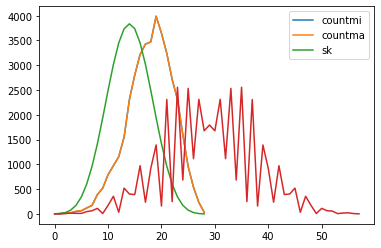

In [10]:
n = 8
P = closed_form_pairwise(n,model='mal_ken', phi=0.5)
losses = np.array([pu.dist_to_sample(perm,P) for perm in it.permutations(range(n))])
dfbounds = get_bounds(P)
countmi = []
for lmi in dfbounds.lmin.values:
  countmi.append(len(losses[losses <= lmi]))
  losses = losses[losses >= lmi]
losses = np.array([pu.dist_to_sample(perm,P) for perm in it.permutations(range(n))])
countma = []
for lma in dfbounds.lmax.values[::-1]:
  countma.append(len(losses[losses >= lma]))
  losses = losses[losses <= lma]
countb = []
losses = np.array([pu.dist_to_sample(perm,P) for perm in it.permutations(range(n))])
for lmi in np.sort( np.concatenate([dfbounds.lmin.values , dfbounds.lmax.values])):
  countb.append(len(losses[losses <= lmi]))
  losses = losses[losses >= lmi]
df = pd.DataFrame()
# df['countb'] = countb
df['countmi'] = countmi
df['countma'] = countma
sk = mk.num_perms_at_dist(n)
df['sk'] = sk[n,:]
df.plot()
plt.plot(countb)

In [11]:
df

,countmi,countma,sk
0,1,1,1
1,7,7,7
2,15,22,27
3,22,24,76
4,47,57,174
5,64,65,343
6,120,120,602
7,173,173,961
8,390,390,1415
9,520,520,1940
